## Example to get predicted submissions file for Kaggle

The following code guides through importing the `train` and `test` csv files, along with basic feature engineering, to get the final predicted sale values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)

In [36]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [37]:
# combining the train and test dataset, without the 'SalePrice' and 'Id' columns now
# so as to not interfere when separating for X_train, X_test, and y

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [38]:
set(list(all_data.KitchenAbvGr))

{0, 1, 2, 3}

In [23]:
#train = train[train.GrLivArea < 4000] # for some reason this destroys the accuracy

Looking at the distrbution of the SalePrice, and a ln(x+1) transformation on SalePrice.

- ln(x+1) is used just in case there are any discontinuities or any values at 0, it will not break the code.

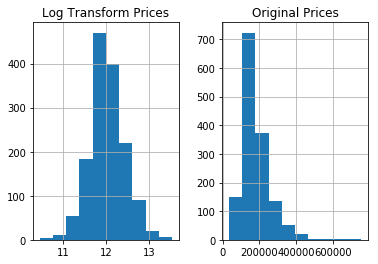

In [24]:
prices = pd.DataFrame({"Original Prices":train["SalePrice"],
                       "Log Transform Prices":np.log1p(train["SalePrice"])})

prices.hist()
plt.show()

As we can see the, the log-transform distribution looks much better than the right-skewed original SalePrice distribution.

In [25]:
print('The skewness value for regular SalePrice is: ' + str(skew(train['SalePrice'])))

The skewness value for regular SalePrice is: 1.880940746034036


In [26]:
# transforming the target variable
train["SalePrice"] = np.log1p(train["SalePrice"])

# the new skewness value
print('The skewness value for the transformed SalePrice is: ' + str(skew(train['SalePrice'])))

The skewness value for the transformed SalePrice is: 0.12122191311528359


Applying this log transform to all the features that have a skewness value above 0.75:

In [27]:
# taking only numeric continuous features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Transforming any categorical columns with strings into dummy columns (so it is either 0 or 1 depending on what category the observation falls into). 

In [10]:
all_data = pd.get_dummies(all_data, drop_first=True)

In [20]:
all_data.shape

(2919, 245)

Imputing any missing values, of which there are a decent amount:

In [34]:
set(list(all_data.KitchenAbvGr))

{0.0, 0.6931471805599453, 1.0986122886681098, 1.3862943611198906}

In [35]:
all_data.isna().sum().sort_values(ascending=False).head(10)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
dtype: int64

Since it doesn't make sense to impute the `LotFrontage` with a value of 0, we can either impute it with the mean or median of that column. Or use KNN (probably the best solution). 

Doing the safe route for now, by imputing the missing values with the median of the column.

In [33]:
set(list(all_data.MasVnrArea))

{0.0,
 nan,
 0.6931471805599453,
 2.833213344056216,
 3.6635616461296463,
 3.713572066704308,
 3.7376696182833684,
 3.871201010907891,
 4.248495242049359,
 4.2626798770413155,
 4.394449154672439,
 4.418840607796598,
 4.442651256490317,
 4.477336814478207,
 4.584967478670572,
 4.59511985013459,
 4.709530201312334,
 4.7535901911063645,
 4.787491742782046,
 4.804021044733257,
 4.812184355372417,
 4.820281565605037,
 4.8283137373023015,
 4.844187086458591,
 4.859812404361672,
 4.875197323201151,
 4.890349128221754,
 4.955827057601261,
 5.087596335232384,
 5.093750200806762,
 5.111987788356544,
 5.135798437050262,
 5.153291594497779,
 5.198497031265826,
 5.220355825078324,
 5.231108616854587,
 5.247024072160486,
 5.262690188904886,
 5.2832037287379885,
 5.288267030694535,
 5.303304908059076,
 5.327876168789581,
 5.337538079701318,
 5.375278407684165,
 5.389071729816501,
 5.4116460518550396,
 5.424950017481403,
 5.459585514144159,
 5.484796933490655,
 5.497168225293202,
 5.5053315359323625,


In [17]:
all_data.LotFrontage = all_data.LotFrontage.fillna(all_data.LotFrontage.median())

The variables make sense to impute with 0, since if the value is missing, it can be assumed that the house does not have that specific feature (i.e. a house without a pool or garage).

In [18]:
all_data = all_data.fillna(0)

Setting the `X_train`, `X_test`, and `y` variables for use with the Lasso Regularization model in sklearn. 

In [21]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [22]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

# Defining a RMSE function to calculate the residual mean squared error to evaluate the model
def rmse_cv(model, X, y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

The `alpha_vals` grid is set rather lazily, but through basic iteration, any lower and the model simply won't converge, or have a higher RMSE.

In [50]:
alpha_vals = np.linspace(0.0005, 1, 100)
#alpha_vals = [1, 0.1, 0.001, 0.0005]
model_lasso = LassoCV(alphas = alpha_vals).fit(X_train, y)
model_lasso.score(X_train, y)

0.9308069186876479

In [55]:
print("With 5-fold CV, the RMSE values are: " + str(rmse_cv(model_lasso, X_train, y)))
print("Average RMSE: " + str(rmse_cv(model_lasso, X_train, y).mean()))

With 5-fold CV, the RMSE values are: [0.10350657 0.13136015 0.12554621 0.10531017 0.14723826]
Average RMSE: 0.1225922726968361


Since lasso regularization works by shrinking the beta coefficients down to potentially zero, the following cells examine how many coefficients were reduced to zero (eliminated features), and of those that were kept, which ones were the most important.

In [56]:
beta_vals = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Variables kept: " + str(sum(beta_vals != 0)))
print("Variables eliminated: " + str(sum(beta_vals == 0)))

Variables kept: 111
Variables eliminated: 177


In [57]:
print(beta_vals.sort_values().head(10))
print(beta_vals.sort_values().tail(10))

RoofMatl_ClyTile        -0.703243
MSZoning_C (all)        -0.292333
Condition2_PosN         -0.190563
Neighborhood_Edwards    -0.052388
SaleCondition_Abnorml   -0.046832
MSZoning_RM             -0.037929
CentralAir_N            -0.035162
GarageCond_Fa           -0.032055
LandContour_Bnk         -0.030943
SaleType_WD             -0.030842
dtype: float64
OverallQual             0.053173
KitchenQual_Ex          0.063831
Exterior1st_BrkFace     0.070378
Neighborhood_NridgHt    0.071545
LotArea                 0.071575
Functional_Typ          0.072469
Neighborhood_NoRidge    0.086291
Neighborhood_Crawfor    0.104851
Neighborhood_StoneBr    0.112555
GrLivArea               0.397878
dtype: float64


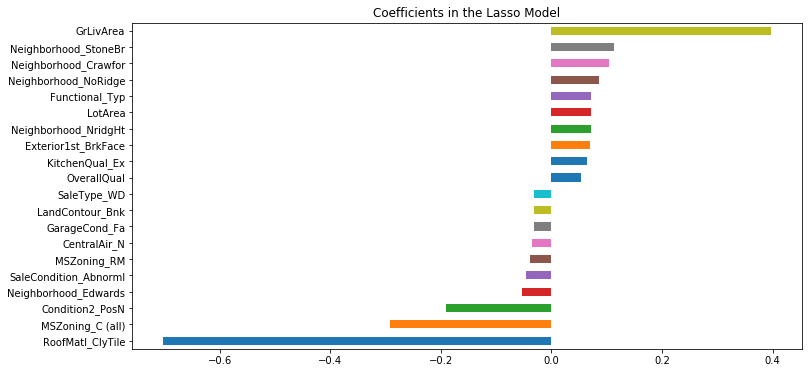

In [58]:
important_feat = pd.concat([beta_vals.sort_values().head(10), beta_vals.sort_values().tail(10)])

important_feat.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

This last cell generated the predictions, and then creates the csv file for Kaggle submission.

As a sidenote, since we performed a log transformation of `np.log1p` on the Sale Price in the beginning, we must do `np.expm1` on the predicted prices to bring it back to the original scale.

In [196]:
pred = np.expm1(model_lasso.predict(X_test))

submission = pd.DataFrame({'Id': test.Id, 'SalePrice': pred})
submission.to_csv('attempt1.csv', index=False)